In [ ]:
#| code-fold: true
#| code-summary: "Download the data"

!git clone https://github.com/judith-tonhauser/projective-probability.git data/projective-probability/

data_dir = "data/"

## Laying out the possibilities

Our question will be: how does this modulation of inference judgments in the projectivity experiments occur? The first thing to ask is how knowledge about a predicate's projectivity $\pi^\text{verb}_v$ might be combined with prior knowledge about likelihood of some propositional contents in some context $\pi^\text{context}_c$. We will consider a very simple general form for this combination: probabilistic fuzzy logic disjunction.

To see why this form is useful for our purposes, let's consider an informal description of how a proponent of the indeterminacy theory might describe what happens when someone makes an inference judgment in the projectivity experiments: decide, on the basis of prior knowledge about how frequently the factive variant of a predicate occurs, whether to select a factive or non-factive variant of the predicate; if you selected a factive variant, respond *yes*; otherwise, respond based on your prior beliefs about the contents.

### Two versions of the indeterminacy hypothesis

In the case where the response is based on prior beliefs, there are two ways one might go. The first is to decide whether the content is true and, if it is responde *yes*; and if it isn't, respond *no*. I will refer to this as the *wholly discrete hypothesis* because all responses are at least intended to be *no* or *yes* (though they may be obcured by noise, response biases, etc.). If $\tau^\text{verb}_n \sim \text{Bernoulli}\left(\pi^\text{verb}_{\text{verb}(n)}\right)$ is the decision about whether or not the verb is factive and $\tau^\text{context}_n \sim \text{Bernoulli}\left(\pi^\text{context}_{\text{context}(n)}\right)$ is the decision about whether the content is true in the relevant context, then we can describe the intended response $n$ (again, up to noise) as $\tau^\text{verb}_n \lor (\tau^\text{verb}_n \rightarrow \tau^\text{context}_n) = \tau^\text{verb}_n \lor \tau^\text{context}_n$. I will refer to this first hypothesis as the *wholly discrete model*.

The second option is to assume that one decides whether or not the verb is factive $\tau^\text{verb}_n \sim \text{Bernoulli}\left(\pi^\text{verb}_{\text{verb}(n)}\right)$, but that if it's not we respond with the raw likelihood $\pi^\text{context}_c$ (again, potentially subject to noise). We can describe this as $\tau^\text{verb}_n \lor \pi^\text{context}_n$, assuming that $\lor$ is interpreted as probabilistic fuzzy logic disjunction: $p \lor p' \equiv = p + (1-p)p' = 1 - (1-p)(1-p')$, where classical disjunction is a special case with $p, p' \in \{0, 1\}$.^[These forms can be derived from an application of de Morgan's laws $p \lor p' = \lnot\lnot(p \lor p') = \lnot(\lnot p \land \lnot p')$ plus an assumption that $p$ and $p'$ parameterize independent Bernoulli distributions.] So then:

$$\tau^\text{verb}_n \lor \pi^\text{context}_n = \begin{cases}
1 & \text{if } \tau^\text{verb}_n = 1\\
\pi^\text{context}_n & \text{otherwise}
\end{cases}$$

I will refer to this second hypothesis as the *verb discrete model*.

### Two versions of the fundamental gradience hypothesis

The setup above suggests two additional possibilities: responding based on $\pi^\text{verb}_n \lor \tau^\text{context}_n$ or responding based on $\pi^\text{verb}_n \lor \pi^\text{context}_n$. The first of these options–which I will refer to as the *context discrete model* is a logical possibility, but it is not clear what kind of theory it might be associated with. Nonetheless, it assumes that responses are based directly on gradient knowledge about the verb. The second of these options–which I will refer to as the *wholly gradient model*–is a more natural fit for an implementation of the fundamental gradience hypothesis: it seems that at least the use of prior knowledge would be gradient; the question is whether is use of the lexical knowledge is as well.

## Prior beliefs

The use we are going to put the norming data collected by @degen_prior_2021 is the estimation of distributions representing prior beliefs about particular contexts. That is, we will use it to estimate a distribution on $\pi^\text{context}_c$.

In [62]:
#| code-fold: true
#| code-summary: "Load the norming data"

import os
from pandas import DataFrame, read_csv

def load_norming_data(fname: str) -> DataFrame:
    data = read_csv(fname, index_col=0)

    data = data[~data.item.isin(["F1", "F2"])]
    
    return data.drop(columns="comments")

data_norming = load_norming_data(
    os.path.join(
        data_dir, 
        "projective-probability/results/1-prior/data/cd.csv"
    )
)

Our main focus in this dataset will be modeling the distribution of respones to each `itemType` + `itemNr`, which corresponds to a particular pairing of `fact` and `prompt`. I'll refer to these together as the *context*.

In [49]:
data_norming[["workerid", "itemType", "itemNr", "prompt", "fact", "response"]].head()

,workerid,itemType,itemNr,prompt,fact,response
1,0,H,12,How likely is it that Frank got a cat?,Frank has always wanted a pet.,0.83
2,0,L,7,How likely is it that Isabella ate a steak on ...,Isabella is a vegetarian.,0.14
3,0,H,10,How likely is it that Zoe calculated the tip?,Zoe is a math major.,0.93
5,0,L,3,How likely is it that Emma studied on Saturday...,Emma is in first grade.,0.64
6,0,L,13,How likely is it that Jackson ran 10 miles?,Jackson is obese.,0.25


Each `prompt` is paired with two different facts: one for which the prompt should elicit higher likelihood responses (`itemType`=`H`) and another for which the prompt should elicit lower likelihood responses (`itemType`=`L`). One example can be seen below.

In [19]:
data_norming_sub = data_norming.query('item.isin(["10H", "10L"])')

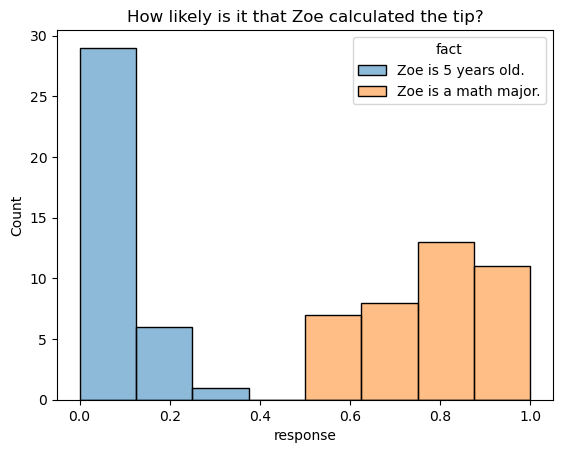

In [29]:
#| code-fold: true
#| code-summary: Plotting code

from seaborn import histplot

p = histplot(
    data=data_norming_sub, x="response", hue="fact", 
    hue_order=["Zoe is 5 years old.", "Zoe is a math major."]
)

_ = p.set_title("How likely is it that Zoe calculated the tip?")

In general, the intended likelihood corresponds quite well to the distribution of responses.

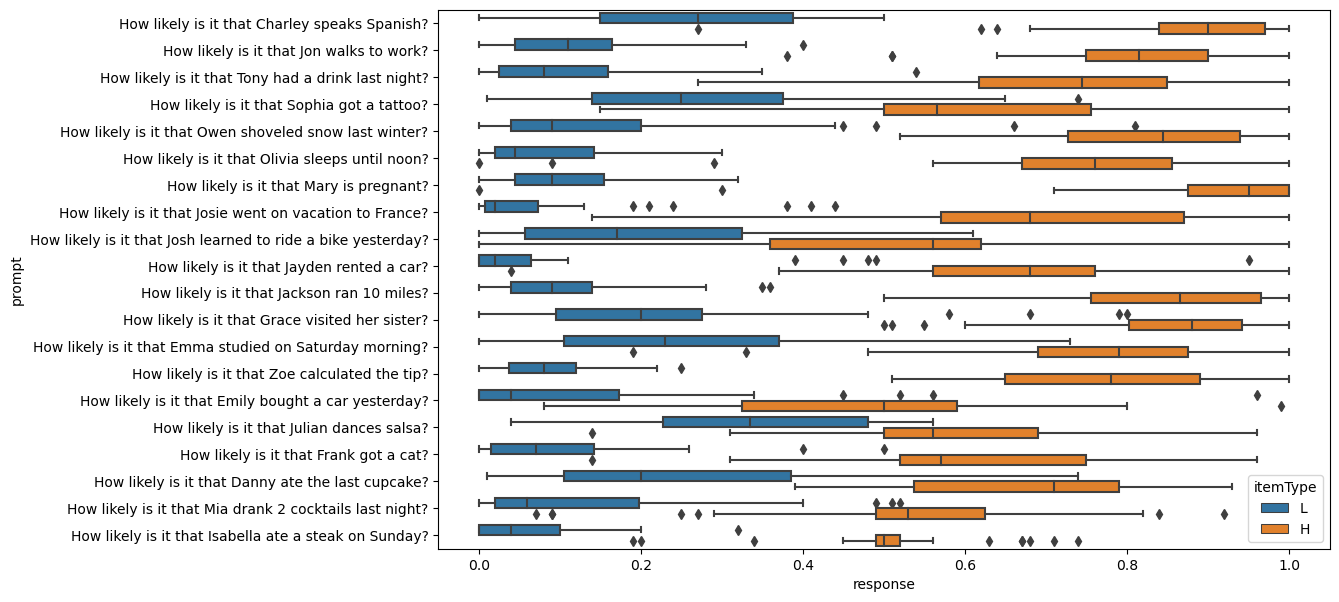

In [84]:
#| code-fold: true
#| code-summary: Plotting code

from matplotlib.pyplot import subplots
from seaborn import boxplot

fig, ax = subplots(figsize=(11.5, 7))

prompt_order = data_norming.groupby("prompt").response.max().sort_values(ascending=False)

_ = boxplot(data_norming, y="prompt", x="response", hue="itemType", hue_order=["L", "H"], order=prompt_order.index)

Before discussing the prior belief model, we need to consider how exactly to model these sorts of bounded scale responses.

### Modeling bounded scale responses

A common way to model bounded scale responses is to assume that responses $Y_n$ are distributed beta with mean $\mu_{\text{item}(n)} \in (0, 1)$ and *sample size* $\nu \in \mathbb{R}_+$: 

$$Y_n \sim \text{Beta}(\nu\mu_{\text{item}(n)}, \nu(1-\mu_{\text{item}(n)}))$$

[This parameterization](https://en.wikipedia.org/wiki/Beta_distribution#Mean_and_sample_size)–in contrast to the parameterization directly in terms of $\alpha$ and $\beta$ that we discussed [here](../foundational-concepts-in-probability-and-statistics/random-variables-and-probability-distributions#beta-distribution)–allows us to more directly model the expected value of $Y_n$, since:

$$\mathbb{E}[Y_n] = \frac{\nu\mu_{\text{item}(n)}}{\nu\mu_{\text{item}(n)} + \nu(1-\mu_{\text{item}(n)})} = \mu_{\text{item}(n)}$$

This ability to more directly model the expected value–rather than having to model the two parameters $\alpha$ and $\beta$ directly–is useful for interpretability. 

One challenge that arises with making this assumption is that the beta distribution does not have support on 0 or 1. This challenge is a real one, since there are a small (but nontrivial) number of 0 and 1 responses in the norming data (as well as the projection data).

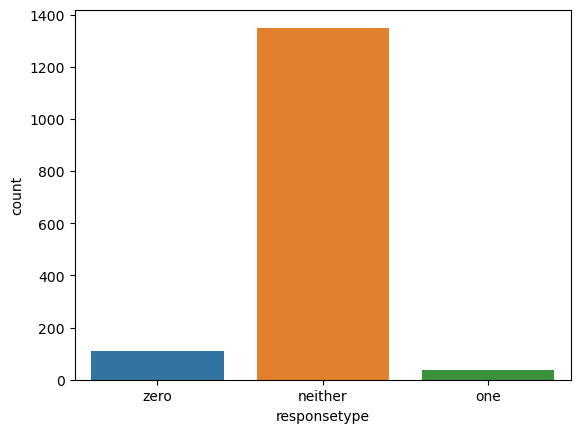

In [50]:
#| code-fold: true
#| code-summary: Plotting code

from seaborn import countplot

def bin_responses(response):
    if response == 1:
        return "one"
    elif response == 0:
        return "zero"
    else:
        return "neither"

data_norming["responsetype"] = data_norming.response.map(bin_responses)

_ = countplot(x = "responsetype", data = data_norming, order = ["zero", "neither", "one"])

One way that researchers deal with this issue–especially when the number of 0 and 1 responses is small is to nudge those responses toward 0.5 slightly. The issue with this approach is that this nudging requires one to specify the amount that the value should be nudged, and that amount can matter a lot for models fit to the data–depending on what sort of model it is. There are at least two ways one might try to avoid this issue. 


#### Zero-one-inflated beta models

The first is to use what is known as a zero-one-inflated beta model. This sort of model assumes that the responses come from some mixture of a continuous random variable $\beta_n \sim \text{Beta}\left(\nu\mu_{\text{item}(n)}, \nu\left(1-\mu_{\text{item}(n)}\right)\right)$ and a Bernoulli random variable $b_n \sim \text{Bern}\left(\pi_{\text{item}(n)}\right)$. The mixture itself is defined in terms of a selection $d_n \sim \text{Bern}\left(\theta\right)$ of which random variable to sample from:

$$Y_n = \begin{cases}
b_n & \text{if } d_n = 1\\
\beta_n & \text{otherwise}\\
\end{cases}$$

This approach is useful because it provides an interpretable way of assessing how likely it is that the model believes the likelihood to be exactly 0 or exactly 1. But besides requiring additional parameters that one would need to design definitions for–$\pi_{\text{item}(n)}$ and $\theta$–this model makes some assumptions that we just don't want to make. 

For instance, it assumes that if you as a responder are targeting 0 or 1 (as indicated by $d_n$), you always hit it exactly. But no one is that accurate; there is always noise in response scale use–especially when you get subjects who are responding very quickly, as crowd-sourced workers tend to. 

Worse, though, is that it basically assumes that all models have some amount of discreteness in them: the Bernoulli-distributed portion of the model. We want to avoid this sort of discreteness in the context of the fundamental gradience hypothesis. This property is the real deal-breaker.

#### Truncated normal models

An alternative model that both reduce this complexity and provides support on $\{0, 1\}$ in addition to $(0, 1)$ uses the [truncated normal distribution](https://en.wikipedia.org/wiki/Truncated_normal_distribution) to model the slider responses.

$$p(y_n; \mu_n, \sigma, a, b) = \begin{cases}
\frac{\mathcal{N}(y_n; \mu_n, \sigma_n^2)}{\Phi(b; \mu_n, \sigma_n^2) - \Phi(a; \mu_n, \sigma_n^2)} & \text{if } y_n \in [a, b]\\
0 & \text{otherwise}
\end{cases}$$

where $\Phi$ is the CDF of the normal distribution. So this distribution basically constrains the support of a $\mathcal{N}(\mu, \sigma^2)$ to $[a, b]$ and then renormalizes the distribution to ensure that it satisfies [the assumption of unit measure](../foundational-concepts-in-probability-and-statistics/#what-it-means-to-measure-a-possibility).^[Importantly, the truncated normal does not behave like the logit-normal distribution, we saw [here](../foundational-concepts-in-probability-and-statistics/statistical-inference#beyond-conjugacy) in the course notes on [statistical inference](../foundational-concepts-in-probability-and-statistics/statistical-inference). As the variance of a truncated normal increases, it tends toward a $\mathcal{U}(a, b)$ distribution. In contrast, when the variance of a logit-normal increases, it tends toward a $\text{Bernoulli}(\text{logit}^{-1}(\mu_n))$ distribution. Further, the logit-normal technically only has support on $(0, 1)$, making it a similarly bad candidate for our linking model.] One way to think of what this distribution assumes is that subjects target some value $\mu_n$ when they respond, but they miss that exact value–e.g. because of uninteresting motor planning factors (and any other potential source of uncorrelated noise).

### The prior belief model

To estimate the distributions over prior knowledge from the data collected by @degen_prior_2021, we use a random effects model with by-subject and by-item random intercepts. I will refer to the latter as by-context random intercepts, since we will need to distinguish by-context intercepts from by-verb intercepts when we begin modeling the projection data, and verbs are also constitutive of the items.

The `data` block needs to specify both the number of subjects and their identity as well as the number of contexts and their identity.

```{.stan include="models/norming-model/norming-model.stan" start-line=12 end-line=19}
```

We use a standard parameterization of the random intercepts $\rho_s^\text{subj} \sim \mathcal{N}(0, \sigma_\text{subj}^2)$ and $\rho_c^\text{context}  \sim \mathcal{N}(0, \sigma_\text{context}^2)$, specified in the `parameters` block.

```{.stan include="models/norming-model/norming-model.stan" start-line=21 end-line=27}
```

To model how by-subject and by-context random intercepts combine, we will view them representations in log-odds space and define $\mu_n \equiv \text{logit}^{-1}\left(\rho_{\text{subj}(n)}^\text{subj} + \rho_{\text{context}(n)}^\text{context}\right)$ in the `transformed parameters` block.

```{.stan include="models/norming-model/norming-model.stan" start-line=29 end-line=33}
```

We could technically define $\mu_n \equiv \rho_{\text{subj}(n)}^\text{subj} + \rho_{\text{context}(n)}^\text{context}$. This definition is possible because the mean of a truncated normal need not itself be in $[a, b]$. The issue with this definition is that it's not really clear what the random intercepts represent. 

Another possibility is to define $\mu_n \equiv \text{logit}^{-1}\left(\rho_{\text{subj}(n)}^\text{subj}\right) + \rho_{\text{context}(n)}^\text{context}$, where $\text{logit}^{-1}\left(\rho_{\text{subj}(n)}^\text{subj}\right) \in (0, 1)$ is interpretable as an average measure (though not technically the mean) for the context and the subject intercepts operate in scale space rather than log-odds space. This definition is a bit odd, however, because it would suggest that subjects can target values below 0 or above 1, and it's not clear what it would mean to intend to respond with a likelihood below 0 or above 1.

In the `model` block, we specify the distributional assumptions for the random effects as well as the truncated normal assumption for the responses.^[We additionally specify fairly strong $\text{Exponential}(1)$ priors on the random effect standard deviations that are necessary for practical reasons having to do with model fitting.]

```{.stan include="models/norming-model/norming-model.stan" start-line=35 end-line=48}
```

Finally, it will be useful to define an additional quantity in the `generated quantities` block: the average likelihood associated with the context when zeroing out the subject intercept. This quantity corresponds to $\pi^\text{context}_c$.

```{.stan include="models/norming-model/norming-model.stan" start-line=50 end-line=59}
```

With the aim of incorporating prior knowledge into our models of projection, what we're going to do with this model is to use it's posterior distribution over each by-context intercept as the prior for our models of the projection data. As we will see, these posterior distributions are very close to normal in log-odds space, so what we will do is to estimate, for each context $c$, a $\mu^\text{context}_c$ and a $\sigma^\text{context}_c$ from the distribution we obtain and place $\rho^\text{context}_c \sim \mathcal{N}\left(\mu^\text{context}_c, \sigma^\text{context}_c\right)$ on the by-context random intercepts $\rho^\text{context}_c$.

## Projection Data

The projection data uses the same set of contexts but embeds the `content` of the prompt under a particular `verb`. The prompt itself also differs: rather than being about the likelihood of the content, it is about whether a speaker is certainty about that content on a bounded slider from *no* to *yes*.

In [63]:
#| code-fold: true
#| code-summary: "Load the norming data"

def load_projection_data(fname: str) -> DataFrame:
    data = read_csv(fname, index_col=0)
    
    if "comments" in data.columns:
        data = data.drop(columns="comments")

    data = data[data.trigger_class != "control"]

    data["itemType"] = data.fact_type.str.replace("fact", "")
    data["item"] = data.contentNr.astype(str) + data.fact_type.str.replace("fact", "")
    
    return data

data_projection = load_projection_data(
    os.path.join(
        data_dir, 
        "projective-probability/results/3-projectivity/data/cd.csv"
    )
)

In [54]:
data_projection[["workerid", "itemType", "verb", "fact", "content", "response"]].head()

,workerid,item,verb,fact,content,response
3,0,8H,establish,Emily has been saving for a year,Emily bought a car yesterday,0.61
4,0,12H,prove,Frank has always wanted a pet,Frank got a cat,0.72
5,0,20H,reveal,Charley lives in Mexico,Charley speaks Spanish,0.92
6,0,19L,confirm,Jon lives 10 miles away from work,Jon walks to work,0.42
7,0,6H,acknowledge,Mia is a college student,Mia drank 2 cocktails last night,0.81


Considering the responses for a verb like `pretend`, we see that, consistent with intuition, they tend to fairly heavily bias toward *no*, with responses for the higher likelihood contexts pushing the distribution slightly toward *yes*.^[I'm following the terminology used by the data in calling this column the `verb` column. This terminology isn't quite right, since there are non-verbal predicates–e.g. *be right*–in the data.] 

In [42]:
data_projection_pretend = data_projection.query("verb == 'pretend'")

,verb,itemType,content,fact,response
21,pretend,L,Owen shoveled snow last winter,Owen lives in New Orleans,0.22
35,pretend,L,Jackson ran 10 miles,Jackson is obese,0.05
60,pretend,H,Danny ate the last cupcake,Danny loves cake,0.03
98,pretend,H,Josh learned to ride a bike yesterday,Josh is a 5-year old boy,0.55
118,pretend,H,Tony had a drink last night,Tony really likes to party with his friends,0.43


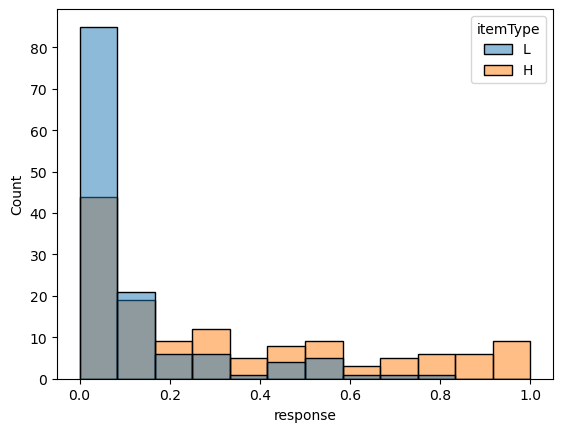

In [38]:
#| code-fold: true
#| code-summary: Plotting code

p = histplot(
    data=data_projection_pretend, x="response", hue="itemType", 
    hue_order=["L", "H"]
)

In contrast, for *know*, we see that, consistent with intuition, responses tend to fairly heavily bias toward *yes*, with responses for the higher likelihood contexts pushing the distribution slightly more toward *yes* and the distribution for the lower likelihood responses pushing the distribution slightly more toward *no*. 

In [41]:
data_projection_know = data_projection.query("verb == 'know'")

,verb,itemType,content,fact,response
15,know,L,Danny ate the last cupcake,Danny is a diabetic,0.97
27,know,H,Owen shoveled snow last winter,Owen lives in Chicago,0.12
55,know,H,Sophia got a tattoo,Sophia is a hipster,0.04
83,know,H,Jackson ran 10 miles,Jackson is training for a marathon,0.74
121,know,L,Frank got a cat,Frank is allergic to cats,0.61


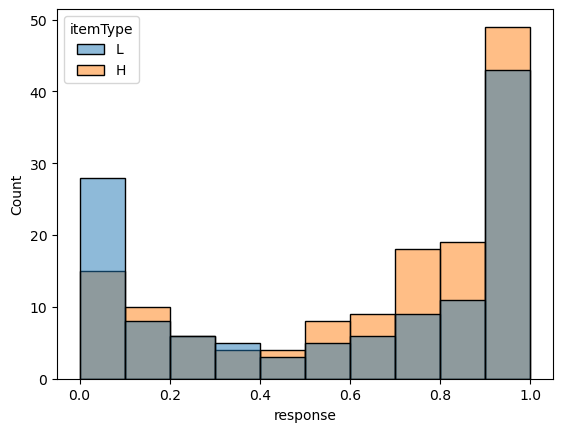

In [43]:
#| code-fold: true
#| code-summary: Plotting code

p = histplot(
    data=data_projection_know, x="response", hue="itemType", 
    hue_order=["L", "H"]
)

This qualitatively observed modulation by `itemType` is indicative of the finding by @degen_prior_2021 that prior knowledge modulates projection. More broadly, we observe this modulation qualitatively when plotting the distributions for all of the predicates.

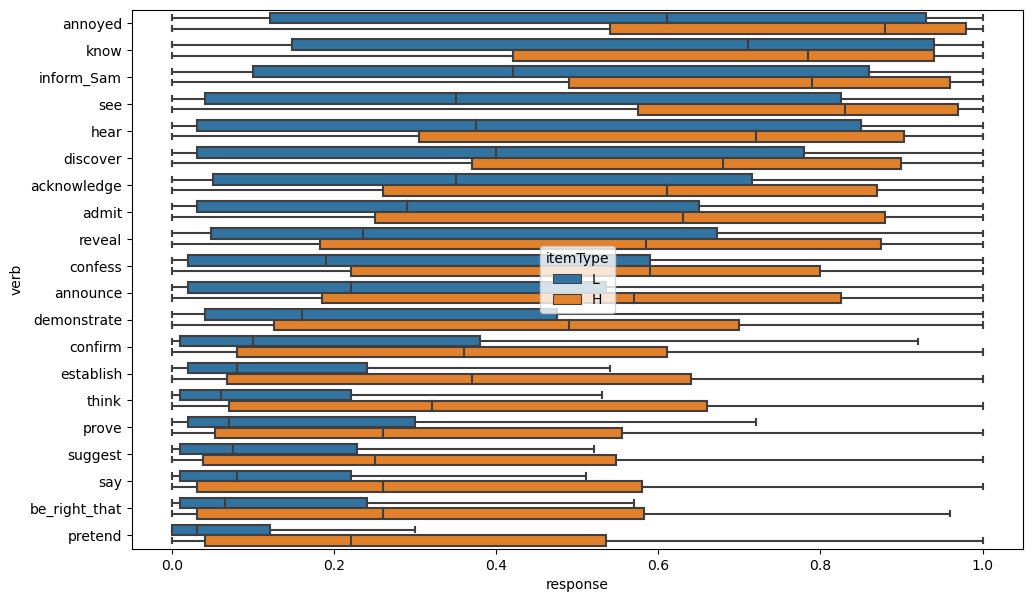

In [88]:
#| code-fold: true
#| code-summary: Plotting code

fig, ax = subplots(figsize=(11.5, 7))

verb_order = data_projection.groupby("verb").response.mean().sort_values(ascending=False)

_ = boxplot(
    data_projection, 
    y="verb", x="response", hue="itemType", 
    hue_order=["L", "H"], order=verb_order.index, 
    ax=ax, fliersize=0.)

### Sparsity in the projection data

In both cases, an important thing to note is how sparse these distributions are: the modulation of the projection repsonses by prior beliefs tends to reveal itself in shifts of the probability mass from one extreme of the scale to the other, which is particularly apparent in the case of *know*. That is, it doesn't appear as though the effect simply shifts the entire down linearly (or as linearly as possible while retaining the bounding on the scale). 

This pattern only really becomes apparent when plotting the full distribution. When plotting using–e.g. boxplots–it gets obscured. It is this sparsity that makes the models assuming some discreteness a live possibility.

### Implementing the models

Each model of this data will differ only in the likelihood function it defines. All such likelihoods are defined either directly as a truncated normal (the fully gradient model) or as a discrete mixture of truncated normals (the three other models). In each case where we need a mixture, we will use the [`log_mix`](https://mc-stan.org/docs/stan-users-guide/vectorizing-mixtures.html).

We'll define these likelihoods in a [`functions` block](https://mc-stan.org/docs/2_18/stan-users-guide/basic-functions-section.html), so that the other pieces of model code can remain the same across models.

*Fully discrete likelihood*
```{.stan include="models/projection-model/fully-discrete/fully-discrete-likelihoods.stan" source-line-numbers="7-15"}
```

*Verb discrete likelihood*
```{.stan include="models/projection-model/verb-discrete/verb-discrete-likelihoods.stan" source-line-numbers="7-15"}
```

*Context discrete likelihood*
```{.stan include="models/projection-model/context-discrete/context-discrete-likelihoods.stan" source-line-numbers="7-15"}
```

*Fully gradient likelihood*
```{.stan include="models/projection-model/fully-gradient/fully-gradient-likelihoods.stan" source-line-numbers="7-11"}
```

The `data` block across all models will remain the same.

```{.stan include="models/projection-model/data-block.stan"}
```

The main thing to note here is that we can specify the estimated parameters $\mu^\text{context}_c$ and  $\sigma^\text{context}_c$ of the posterior over the by-context intercepts.^[We can specify similar parameters $\mu^\text{verb}_v$ and  $\sigma^\text{verb}_v$. We'll return to this possibility in a second.]

The parameters and model themselves are defined using what's known as a [non-centered parameterization](https://mc-stan.org/docs/stan-users-guide/reparameterization.html) [@papaspiliopoulos_general_2007]. In this sort of parameterization, which is used mainly for practical reasons, we define distributions like $\rho \sim \mathcal{N}(\mu, \sigma^2)$ in terms of draws from a standard normal $Z \sim \mathcal{N}(0, 1)$ along with a shift and scale by $\mu$ and $\sigma$, respectively: $\rho \equiv \sigma Z + \mu$. This reparameterization works–i.e. when defined in terms of $Z$ in this way, $\rho \sim \mathcal{N}(\mu, \sigma^2)$ for reasons mentioned [here](https://en.wikipedia.org/wiki/Normal_distribution#General_normal_distribution). 

This reparameterization is the reason for the `_z` variables in the `parameters` block.

```{.stan include="models/projection-model/parameters-and-model-block/parameters-and-model-block-context-prior-fixed.stan" start-line=1 end-line=10}
```

And it's why the `transformed parameters` block defines the intercept terms in the way it does.

```{.stan include="models/projection-model/parameters-and-model-block/parameters-and-model-block-context-prior-fixed.stan" start-line=12 end-line=39}
```

One thing to note about both of these blocks is that we assume by-subject intercepts shifting both the by-context intercepts and the by-verb intercepts. The reasoning here is that particular subjects may tend upweight or downweight the projectivity of verbs in general or they may upweight or downweight the likelihood of the content; and there need not be a correlation between the two.

Note also that the `transformed parameters` block is where we compute our (log-)likelihood using the model-specific likelihood specified in the `functions` block.

The `model` block then simply specifies the random effects assumptions and adds the likelihood for each response to `target`.

```{.stan include="models/projection-model/parameters-and-model-block/parameters-and-model-block-context-prior-fixed.stan" start-line=41 end-line=60}
```

The `generated quantities` block does something similar to our model for the norming data by computing $\pi^\text{context}_c$–additionally computing $\pi^\text{verb}_v$. 

```{.stan include="models/projection-model/generated-quantities-block.stan"}
```

## Additional experiments

To further evaluate our models of the data collected by @degen_prior_2021, we'll look at a couple of additional (unpublished) datasets–collected by @grove_presupposition_inprep–that combine the prompt used by Degen and Tonhauser with the item construction method used for the MegaVeridicality and MegaIntentionsality datasets. In both cases, we attempt to remove all information that one might use for forming prior beliefs about the contents of the complement in order to assess how well the models fit to Degen and Tonhauser's capture information about the verb.

The main difference between the model we'll use for these datasets and the one we developed for Degen and Tonhauser's data is that, rather than specifying context-specific priors on the context intercepts, we will specify verb-specific priors on the verb intercepts. We'll derive the estimates for these priors from our fits to Degen and Tonhauser's projection data in the same way we estimated the context-specific priors from the our fits to their norming data. 

Implementing this idea requires two small changes to the `parameters` block: (a) adding a `context_intercept_std` for the prior over context intercepts and (b) removing the `verb_intercept_std`, since it is specified.

```{.stan include="models/projection-model/parameters-and-model-block/parameters-and-model-block-verb-prior-fixed.stan" start-line=1 end-line=10}
```

In the `transformed parameters` block, we similarly need to flip how we deal with by-verb and by-context intercepts. The rest remains the same.

```{.stan include="models/projection-model/parameters-and-model-block/parameters-and-model-block-verb-prior-fixed.stan" start-line=12 end-line=39 source-line-numbers="2-6"}
```

Finally, we need to do something similar in the `model` block.

```{.stan include="models/projection-model/parameters-and-model-block/parameters-and-model-block-verb-prior-fixed.stan" start-line=41 end-line=60 source-line-numbers="2-7"}
```

### Bleached contexts

In our bleached context experiments–which use an item construction method analogous to the one used for MegaVeridicality by @white_role_2018–we use an analogous prompt to the one that Degen and Tonhauser use, where $P_1$ and $P_2$ are replaced with randomly selected names and $V$ is replaced with one of the verbs from the original experiment.

> You are at a party. You walk into the kitchen and overhear $P_1$ ask somebody else a question. $P_1$ doesn't know you and wants to be secretive, so speaks in somewhat coded language.

> **$P_1$ asks:** "Did $P_2$ $V$ that a particular thing happened?"

> Is $P_1$ certain that that thing happened?

In [64]:
#| code-fold: true
#| code-summary: "Load the bleached data"

data_projection_bleached = load_projection_data(
    os.path.join(
        data_dir, 
        "projective-probability-replication/bleached.csv"
    )
)

The correlation between the mean response in this experiment and the one in Degen and Tonhauser's experiment is extremely high.

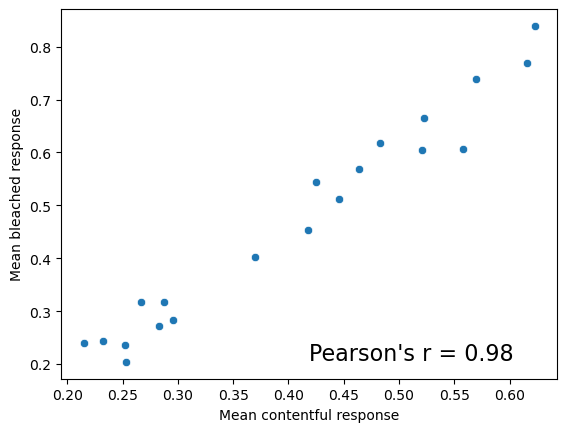

In [78]:
#| code-fold: true
#| code-summary: Plotting code

from scipy.stats import pearsonr
from pandas import merge
from seaborn import scatterplot

ax = subplot()

bleached_verb_mean = data_projection_bleached.groupby("verb").response.mean()
contentful_verb_mean = data_projection.groupby("verb").response.mean()

verb_means_bleached = merge(
    bleached_verb_mean, contentful_verb_mean, 
    left_index=True, right_index=True
).rename(columns={
    "response_x": "Mean bleached response",
    "response_y": "Mean contentful response"
})

scatterplot(verb_means_bleached, x="Mean contentful response", y="Mean bleached response", ax=ax)

r, p = pearsonr(x=verb_means_bleached["Mean contentful response"], y=verb_means_bleached["Mean bleached response"])
_ = ax.text(.5, .05, "Pearson's r = {:.2f}".format(r), fontdict={"fontsize": 16}, transform=ax.transAxes)

### Templatic contexts

In our templatic context experiments–which use an item construction method analogous to the one used for MegaVeridicality by @kane_intensional_2022–we also use an analogous prompt to the one that Degen and Tonhauser use, where $P_1$ and $P_2$ are replaced with randomly selected names and $V$ is replaced with one of the verbs from the original experiment.

> You are at a party. You walk into the kitchen and overhear $P_1$ ask somebody else a question. The party is very noisy, and you only hear part of what is said. The part you don't hear is represented by the 'X'.

> **$P_1$ asks:** "Did $P_2$ $V$ that X happened?"

> Is $P_1$ certain that X happened?

In [80]:
#| code-fold: true
#| code-summary: "Load the templatic data"

data_projection_templatic = load_projection_data(
    os.path.join(
        data_dir, 
        "projective-probability-replication/templatic.csv"
    )
)

We again see an extremely high correlation between the mean response in this experiment and the one in Degen and Tonhauser's experiment.

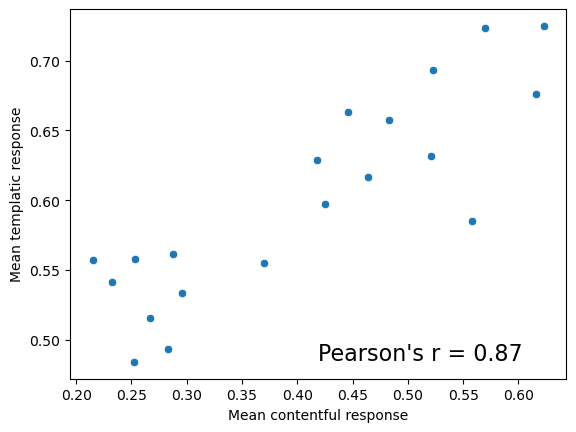

In [82]:
#| code-fold: true
#| code-summary: Plotting code

from scipy.stats import pearsonr
from pandas import merge
from seaborn import scatterplot

ax = subplot()

templatic_verb_mean = data_projection_templatic.groupby("verb").response.mean()

verb_means_templatic = merge(
    templatic_verb_mean, contentful_verb_mean, 
    left_index=True, right_index=True
).rename(columns={
    "response_x": "Mean templatic response",
    "response_y": "Mean contentful response"
})

scatterplot(verb_means_templatic, x="Mean contentful response", y="Mean templatic response", ax=ax)

r, p = pearsonr(x=verb_means_templatic["Mean contentful response"], y=verb_means_templatic["Mean templatic response"])
_ = ax.text(.5, .05, "Pearson's r = {:.2f}".format(r), fontdict={"fontsize": 16}, transform=ax.transAxes)